In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
%matplotlib inline
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}
#foreground_classes = {'bird', 'cat', 'deer'}
background_classes = {'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}
#background_classes = {'plane', 'car', 'dog', 'frog', 'horse','ship', 'truck'}

fg1,fg2,fg3 = 0,1,2

In [4]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

In [5]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]])#.type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx])#.type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]-fg1  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [6]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  np.random.seed(i)
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)

In [7]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]
batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=False,num_workers=0,)

In [8]:
data,labels,fg_index = iter(train_loader).next()

In [9]:
bg = []
for i in range(120):
  torch.manual_seed(i)
  betag = torch.randn(250,9)#torch.ones((250,9))/9
  a=bg.append( betag.requires_grad_() )

In [10]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,y):  #z batch of list of 9 images
    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.view(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1

In [11]:
torch.manual_seed(1234)
what_net = Module2().double()

#what_net.load_state_dict(torch.load("simultaneous_what.pt"))
what_net = what_net.to("cuda")

In [12]:
def attn_avg(x,beta):
  y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
  y = y.to("cuda")
  alpha = F.softmax(beta,dim=1)   # alphas
  for i in range(9):            
    alpha1 = alpha[:,i]          
    y = y + torch.mul(alpha1[:,None,None,None],x[:,i])
  return y,alpha


In [13]:
def calculate_attn_loss(dataloader,what,criter):
  what.eval()
  r_loss = 0
  alphas = []
  lbls = []
  pred = []
  fidices = []
  correct = 0
  tot = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels,fidx= data
      lbls.append(labels)
      fidices.append(fidx)
      inputs = inputs.double()
      beta = bg[i]  # alpha for ith batch
      inputs, labels,beta = inputs.to("cuda"),labels.to("cuda"),beta.to("cuda")
      avg,alpha = attn_avg(inputs,beta)
      alpha = alpha.to("cuda")
      outputs = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      correct += sum(predicted == labels)
      tot += len(predicted)
      pred.append(predicted.cpu().numpy())
      alphas.append(alpha.cpu().numpy())
      loss = criter(outputs, labels)
      r_loss += loss.item()
  alphas = np.concatenate(alphas,axis=0)
  pred = np.concatenate(pred,axis=0)
  lbls = np.concatenate(lbls,axis=0)
  fidices = np.concatenate(fidices,axis=0)
  #print(alphas.shape,pred.shape,lbls.shape,fidices.shape) 
  analysis = analyse_data(alphas,lbls,pred,fidices)
  return r_loss/i,analysis,correct.item(),tot,correct.item()/tot

In [14]:
# for param in what_net.parameters():
#     param.requires_grad = False

In [15]:
def analyse_data(alphas,lbls,predicted,f_idx):
    '''
       analysis data is created here
    '''
    batch = len(predicted)
    amth,alth,ftpt,ffpt,ftpf,ffpf = 0,0,0,0,0,0
    for j in range (batch):
      focus = np.argmax(alphas[j])
      if(alphas[j][focus] >= 0.5):
        amth +=1
      else:
        alth +=1
      if(focus == f_idx[j] and predicted[j] == lbls[j]):
        ftpt += 1
      elif(focus != f_idx[j] and predicted[j] == lbls[j]):
        ffpt +=1
      elif(focus == f_idx[j] and predicted[j] != lbls[j]):
        ftpf +=1
      elif(focus != f_idx[j] and predicted[j] != lbls[j]):
        ffpf +=1
    #print(sum(predicted==lbls),ftpt+ffpt)
    return [ftpt,ffpt,ftpf,ffpf,amth,alth]

In [16]:
optim1 = []
for i in range(120):
  optim1.append(optim.RMSprop([bg[i]], lr=10))

In [17]:
# instantiate optimizer
optimizer_what = optim.RMSprop(what_net.parameters(), lr=0.001)#, momentum=0.9)#,nesterov=True)


 


criterion = nn.CrossEntropyLoss()
acti = []
analysis_data_tr = []
analysis_data_tst = []
loss_curi_tr = []
loss_curi_tst = []
epochs = 100


# calculate zeroth epoch loss and FTPT values
running_loss,anlys_data,correct,total,accuracy = calculate_attn_loss(train_loader,what_net,criterion)
print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(0,running_loss,correct,total,accuracy)) 
loss_curi_tr.append(running_loss)
analysis_data_tr.append(anlys_data)




# training starts 
for epoch in range(epochs): # loop over the dataset multiple times
  ep_lossi = []
  running_loss = 0.0
  what_net.train()
  for i, data in enumerate(train_loader, 0):
    # get the inputs
    inputs, labels,_  = data
    inputs = inputs.double()
    beta = bg[i] # alpha for ith batch
    inputs, labels,beta = inputs.to("cuda"),labels.to("cuda"),beta.to("cuda")
        
    # zero the parameter gradients
    optimizer_what.zero_grad()
    optim1[i].zero_grad()
      
    # forward + backward + optimize
    avg,alpha = attn_avg(inputs,beta)
    outputs = what_net(avg)     
    loss = criterion(outputs, labels)

    # print statistics
    running_loss += loss.item()
    #alpha.retain_grad()
    loss.backward(retain_graph=False)
    optimizer_what.step()
    optim1[i].step()


  running_loss_tr,anls_data,correct,total,accuracy = calculate_attn_loss(train_loader,what_net,criterion)
  analysis_data_tr.append(anls_data)
  loss_curi_tr.append(running_loss_tr)   #loss per epoch
  print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(epoch+1,running_loss_tr,correct,total,accuracy)) 


  
  if running_loss_tr<=0.08:
    break
print('Finished Training run ')
analysis_data_tr = np.array(analysis_data_tr)



training epoch: [0 ] loss: 1.119 correct: 10137.000, total: 30000.000, accuracy: 0.338
training epoch: [1 ] loss: 1.014 correct: 17661.000, total: 30000.000, accuracy: 0.589
training epoch: [2 ] loss: 0.842 correct: 18926.000, total: 30000.000, accuracy: 0.631
training epoch: [3 ] loss: 0.844 correct: 20763.000, total: 30000.000, accuracy: 0.692
training epoch: [4 ] loss: 0.800 correct: 21621.000, total: 30000.000, accuracy: 0.721
training epoch: [5 ] loss: 0.797 correct: 21686.000, total: 30000.000, accuracy: 0.723
training epoch: [6 ] loss: 0.794 correct: 21731.000, total: 30000.000, accuracy: 0.724
training epoch: [7 ] loss: 0.799 correct: 21853.000, total: 30000.000, accuracy: 0.728
training epoch: [8 ] loss: 0.804 correct: 21926.000, total: 30000.000, accuracy: 0.731
training epoch: [9 ] loss: 0.817 correct: 21895.000, total: 30000.000, accuracy: 0.730
training epoch: [10 ] loss: 0.813 correct: 21891.000, total: 30000.000, accuracy: 0.730
training epoch: [11 ] loss: 0.803 correct:

In [18]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = np.arange(0,epoch+2)
df_train[columns[1]] = analysis_data_tr[:,-2]
df_train[columns[2]] = analysis_data_tr[:,-1]
df_train[columns[3]] = analysis_data_tr[:,0]
df_train[columns[4]] = analysis_data_tr[:,1]
df_train[columns[5]] = analysis_data_tr[:,2]
df_train[columns[6]] = analysis_data_tr[:,3]

In [19]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,2758,27242,1070,9067,2140,17723
1,1,18271,11729,2766,14895,1211,11128
2,2,29319,681,4983,13943,1134,9940
3,3,29989,11,5580,15183,967,8270
4,4,29992,8,5775,15846,805,7574
...,...,...,...,...,...,...,...
96,96,30000,0,6067,16886,609,6438
97,97,30000,0,6084,16766,594,6556
98,98,30000,0,5958,16165,718,7159
99,99,30000,0,6030,16621,645,6704


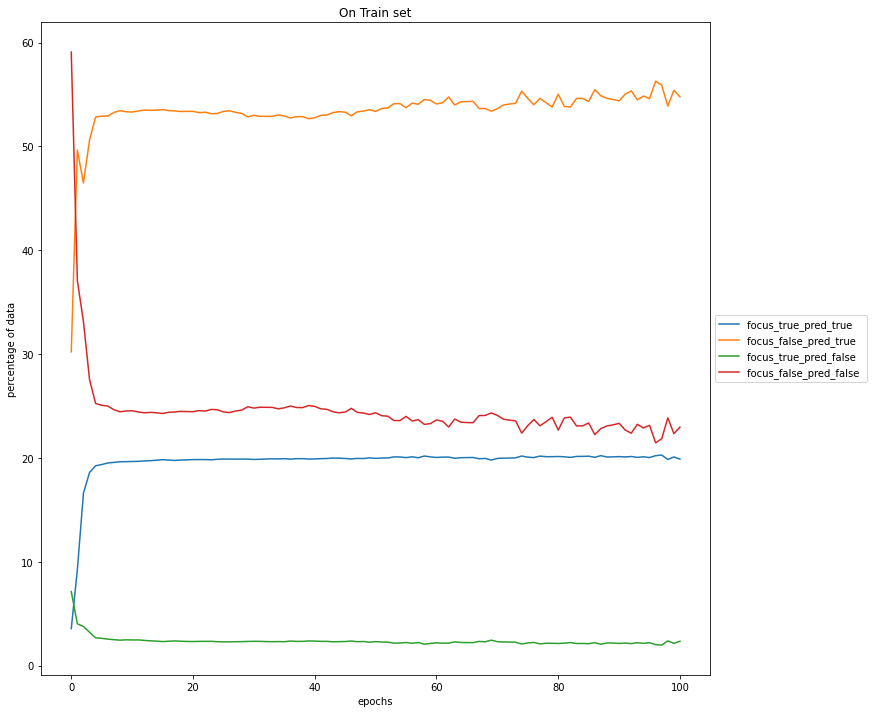

In [20]:
fig= plt.figure(figsize=(12,12))
plt.plot(df_train[columns[0]],df_train[columns[3]]/300, label ="focus_true_pred_true ")
plt.plot(df_train[columns[0]],df_train[columns[4]]/300, label ="focus_false_pred_true ")
plt.plot(df_train[columns[0]],df_train[columns[5]]/300, label ="focus_true_pred_false ")
plt.plot(df_train[columns[0]],df_train[columns[6]]/300, label ="focus_false_pred_false ")
plt.title("On Train set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("percentage of data")
#plt.vlines(vline_list,min(min(df_train[columns[3]]/300),min(df_train[columns[4]]/300),min(df_train[columns[5]]/300),min(df_train[columns[6]]/300)), max(max(df_train[columns[3]]/300),max(df_train[columns[4]]/300),max(df_train[columns[5]]/300),max(df_train[columns[6]]/300)),linestyles='dotted')
plt.show()
fig.savefig("train_analysis.pdf")
fig.savefig("train_analysis.png")

In [21]:
aph = []
for i in bg:
  aph.append(F.softmax(i,dim=1).detach().numpy())
  
aph = np.concatenate(aph,axis=0)
torch.save({
            'epoch': 500,
            'model_state_dict': what_net.state_dict(),
            #'optimizer_state_dict': optimizer_what.state_dict(),
            "optimizer_alpha":optim1,
            "FTPT_analysis":analysis_data_tr,
            "alpha":aph

            }, "cifar_what_net_500.pt")

In [22]:
aph

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        1.4153114e-43, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.4222872e-30, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [23]:
running_loss_tr,anls_data,correct,total,accuracy = calculate_attn_loss(train_loader,what_net,criterion)

In [24]:
print("argmax>0.5",anls_data[-2])

argmax>0.5 30000
